**IMPLEMENTATION OF MOBILENETV2 FOR RECOGNIZING HAND GESTURE TO CONTROL VOLUME OF COMPUTER**

by.Haikal Ramadhan Usman

# ABSTRACT

There are several ways for human to communicate with others. Hand Gesture is one of those several ways to communicate. It is an approach that explains and expresses what is in our mind and transfer it to other human and therefore hand gesture is often called a non-verbal form of communication. In this project, the author will use mobilenetv2 for recognizing the Hand Gesture to make it easier for controlling computer. The idea of making the Hand Gesture recognition is to make it easier for us to control the computer.

# INTRODUCTION

### Background

Technology that being used to controlling device based on voice like virtual assistant such as Google Assistant, Bixby, Alexa, and Siri. For some people who does not like to speak, this technology does not affect very much. That is why they need a technology to controlling the device with gesture.

That is the purpose of this project. Creating technology to control volume with hand gesture. Now, imagine how if our computer does understand what is in our mind with a hand gesture. It should be easier for us to control our laptop. This technology could help people with disability to control their device. It can also be used to help people who does not want to move the mouse or who does not want to type on the keyboard and people who cannot reach their device.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
tf.keras.backend.clear_session()

### Sample of Data


The data that will be used in this project will be collected from Kaggle (https://www.kaggle.com/belalelwikel/asl-and-some-words). It is a sign language base on American sign language (ASL). The dataset contains very large sign language data of number from 1-9, Alphabet from A-Z and some words. in this project I have chosen 2 classes, it is  sign of ‘5’ and the sign of ‘yes’. The sign of ‘5’ will be used to decrease the volume, and sign of ‘yes’ will be used to increase the volume.

In [2]:
train_dir=r'C:/Users/haika/HACKTIV8/Final Project/dataFistPalm/Train/' # directory of training data
validation_dir=r'C:/Users/haika/HACKTIV8/Final Project/dataFistPalm/Val/' # directory of validation data
test_folder=r'C:/Users/haika/HACKTIV8/Final Project/dataFistPalm/Test/' # directory of test data

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 5800 files belonging to 2 classes.


In [4]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 400 files belonging to 2 classes.


In [5]:
test_dataset = image_dataset_from_directory(test_folder,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

Found 1798 files belonging to 2 classes.


Sign of '5' represent by palm and sign of 'yes' represent by fist. We will us palm to decrease the volume and fist to increase the volume.

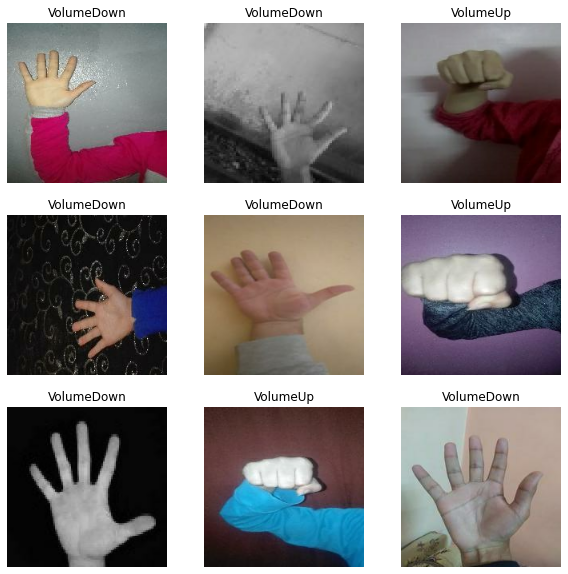

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
#plt.savefig('dataset')

### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the data performance guide.

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

Data augmentation will be used in this project to help expose the model to different aspects of the training data and reduce overfitting. Data augmentation is a way to applying transformation to training data. In this project images will be flipped, Rotated and Cropped.

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
  tf.keras.layers.experimental.preprocessing.CenterCrop(110, 110)
])
# flip, rotate and croped

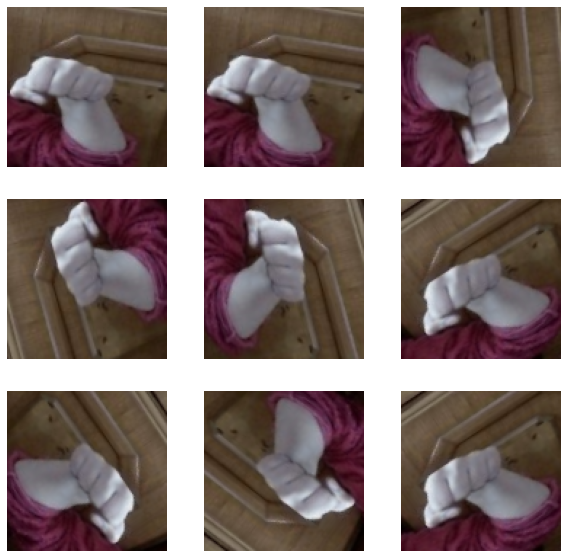

In [9]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')
plt.savefig('data augmentation')

### Rescale pixel values

We will use tf.keras.applications.MobileNetV2 for use as the base model. This model expects pixel values in [-1, 1], but the pixel values our dataset images are in [0, 255]. To rescale all the images, use the preprocessing method included with the model.

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

### Create the base model from the pre-trained convnets

This project will be created based on python programming language and will be using transfer learning method. It is a method of using a pretrained model that has already trained on a very large data. The use of pretrained model for object detection requires quite expensive devices such as GPUs or high enough PC specifications. MobileNetV2 can be used to overcome this problem. MobileNetV2 is a pretrained model developed by google and has already trained on very large dataset.

In [12]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images:

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [14]:
base_model.trainable = False

In [15]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

#### Add a classification head

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [17]:
prediction_layer = tf.keras.layers.Dense(2)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [18]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with from_logits=True since the model provides a linear output.

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 110, 110, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 110, 110, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 110, 110, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

# Train the model

### checkpoint to save the model

In [21]:
checkpoint_path = "C:/Users/haika/HACKTIV8/Final Project/dataFistPalm/checkFistPalm/cp7.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

### training model

In [131]:
# initial_epochs = 10

# loss0, accuracy0 = model.evaluate(validation_dataset)

13/13 [==============================] - 1s 89ms/step - loss: 1.2475 - accuracy: 0.5175


In [132]:
# print("initial loss: {:.2f}".format(loss0))
# print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.25
initial accuracy: 0.52


In [133]:
# history = model.fit(train_dataset,
#                     epochs=initial_epochs,
#                     validation_data=validation_dataset, 
#                     callbacks=[cp_callback])

Epoch 1/10
181/182 [============================>.] - ETA: 0s - loss: 0.8430 - accuracy: 0.6488
Epoch 00001: saving model to C:/Users/haika/HACKTIV8/Final Project/dataFistPalm/checkFistPalm\cp7.ckpt
182/182 [==============================] - 24s 131ms/step - loss: 0.8423 - accuracy: 0.6491 - val_loss: 0.3520 - val_accuracy: 0.8150
Epoch 2/10
181/182 [============================>.] - ETA: 0s - loss: 0.3709 - accuracy: 0.8367
Epoch 00002: saving model to C:/Users/haika/HACKTIV8/Final Project/dataFistPalm/checkFistPalm\cp7.ckpt
182/182 [==============================] - 25s 135ms/step - loss: 0.3705 - accuracy: 0.8369 - val_loss: 0.3379 - val_accuracy: 0.8125
Epoch 3/10
181/182 [============================>.] - ETA: 0s - loss: 0.2410 - accuracy: 0.8990
Epoch 00003: saving model to C:/Users/haika/HACKTIV8/Final Project/dataFistPalm/checkFistPalm\cp7.ckpt
182/182 [==============================] - 25s 136ms/step - loss: 0.2409 - accuracy: 0.8990 - val_loss: 0.2909 - val_accuracy: 0.8475
E

# Result

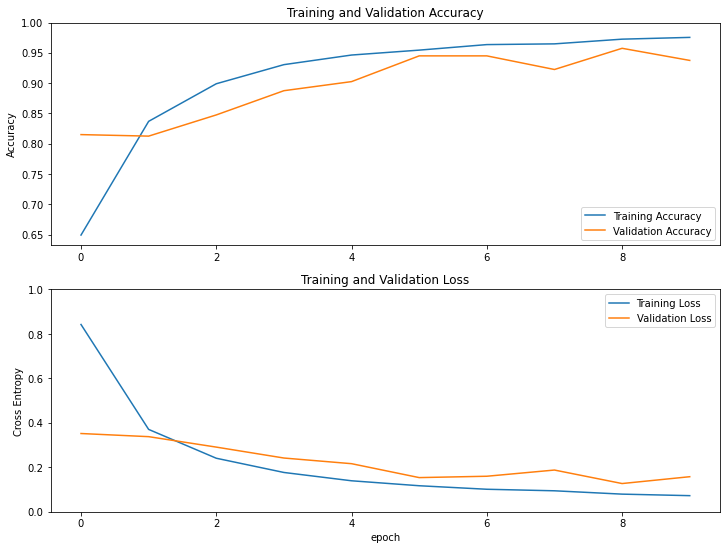

In [170]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# plt.figure(figsize=(12, 9))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.savefig('Accuracy')
# plt.show()


The learning curves are looking good. Training and validation loss are not really overfitting. Training Accuracy and Validation Accuracy are not really overfitting too.


### Evaluation and prediction

Verify the performance of the model with data test.

In [139]:
# loss, accuracy = model.evaluate(test_dataset)
# print('Test accuracy :', accuracy)

57/57 [==============================] - 7s 117ms/step - loss: 0.0870 - accuracy: 0.9778
Test accuracy : 0.9777530431747437


I tried to verify the performance of the model using test dataset and got an accuracy of 0.9778 and loss of 0.087

### Predict

In [22]:
model.load_weights(checkpoint_path)

In [23]:
test_image = r'C:/Users/haika/HACKTIV8/Final Project/dataFistPalm/Yes_101.jpg'

img = keras.preprocessing.image.load_img(
    test_image, target_size=IMG_SIZE
)

In [27]:
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to VolumeUp with a 99.51 percent confidence.


In [25]:
"""
C struct definitions credit

Author: LucasG (https://github.com/lucasg)
Source: http://stackoverflow.com/questions/13564851/generate-keyboard-events
"""

import time
import ctypes

# Import the SendInput object
SendInput = ctypes.windll.user32.SendInput

# C struct redefinitions
PUL = ctypes.POINTER(ctypes.c_ulong)

class KeyBdInput(ctypes.Structure):
    _fields_ = [
        ("wVk", ctypes.c_ushort),
        ("wScan", ctypes.c_ushort),
        ("dwFlags", ctypes.c_ulong),
        ("time", ctypes.c_ulong),
        ("dwExtraInfo", PUL)
    ]

class HardwareInput(ctypes.Structure):
    _fields_ = [
        ("uMsg", ctypes.c_ulong),
        ("wParamL", ctypes.c_short),
        ("wParamH", ctypes.c_ushort)
    ]

class MouseInput(ctypes.Structure):
    _fields_ = [
        ("dx", ctypes.c_long),
        ("dy", ctypes.c_long),
        ("mouseData", ctypes.c_ulong),
        ("dwFlags", ctypes.c_ulong),
        ("time",ctypes.c_ulong),
        ("dwExtraInfo", PUL)
    ]

class Input_I(ctypes.Union):
    _fields_ = [
        ("ki", KeyBdInput),
        ("mi", MouseInput),
        ("hi", HardwareInput)
    ]

class Input(ctypes.Structure):
    _fields_ = [
        ("type", ctypes.c_ulong),
        ("ii", Input_I)
    ]

class Keyboard:
    """
    Class Keyboard
    :author: Paradoxis <luke@paradoxis.nl>
    :description:

    Keyboard methods to trigger fake key events
    """

    # Keyboard key constants
    # More information: https://msdn.microsoft.com/en-us/library/windows/desktop/dd375731(v=vs.85).aspx
    
    VK_BACKSPACE = 0x08
    VK_ENTER = 0x0D
    VK_CTRL = 0x11
    VK_ALT = 0x12
    VK_0 = 0x30
    VK_1 = 0x31
    VK_2 = 0x32
    VK_3 = 0x33
    VK_4 = 0x34
    VK_5 = 0x35
    VK_6 = 0x36
    VK_7 = 0x37
    VK_8 = 0x38
    VK_9 = 0x39
    VK_A = 0x41
    VK_B = 0x42
    VK_C = 0x43
    VK_D = 0x44
    VK_E = 0x45
    VK_F = 0x46
    VK_G = 0x47
    VK_H = 0x48
    VK_I = 0x49
    VK_J = 0x4A
    VK_K = 0x4B
    VK_L = 0x4C
    VK_M = 0x4D
    VK_N = 0x4E
    VK_O = 0x4F
    VK_P = 0x50
    VK_Q = 0x51
    VK_R = 0x52
    VK_S = 0x53
    VK_T = 0x54
    VK_U = 0x55
    VK_V = 0x56
    VK_W = 0x57
    VK_X = 0x58
    VK_Y = 0x59
    VK_Z = 0x5A
    VK_VOLUME_MUTE = 0xAD
    VK_VOLUME_DOWN = 0xAE
    VK_VOLUME_UP = 0xAF
    VK_MEDIA_NEXT_TRACK = 0xB0
    VK_MEDIA_PREV_TRACK = 0xB1
    VK_MEDIA_PLAY_PAUSE = 0xB3
    VK_MEDIA_STOP = 0xB2
    VK_LBUTTON = 0x01
    VK_RBUTTON = 0x02
    VK_CANCEL = 0x03
    VK_MBUTTON = 0x04
    VK_XBUTTON1 = 0x05
    VK_XBUTTON2 = 0x06
    VK_BACK = 0x08
    VK_TAB = 0x09
    VK_CLEAR = 0x0C
    VK_RETURN = 0x0D
    VK_SHIFT = 0x10
    VK_CONTROL = 0x11
    VK_MENU = 0x12
    VK_PAUSE = 0x13
    VK_CAPITAL = 0x14
    VK_KANA = 0x15
    VK_HANGUEL = 0x15
    VK_HANGUL = 0x15
    VK_JUNJA = 0x17
    VK_FINAL = 0x18
    VK_HANJA = 0x19
    VK_KANJI = 0x19
    VK_ESCAPE = 0x1B
    VK_CONVERT = 0x1C
    VK_NONCONVERT = 0x1D
    VK_ACCEPT = 0x1E
    VK_MODECHANGE = 0x1F
    VK_SPACE = 0x20
    VK_PRIOR = 0x21
    VK_NEXT = 0x22
    VK_END = 0x23
    VK_HOME = 0x24
    VK_LEFT = 0x25
    VK_UP = 0x26
    VK_RIGHT = 0x27
    VK_DOWN = 0x28
    VK_SELECT = 0x29
    VK_PRINT = 0x2A
    VK_EXECUTE = 0x2B
    VK_SNAPSHOT = 0x2C
    VK_INSERT = 0x2D
    VK_DELETE = 0x2E
    VK_HELP = 0x2F
    VK_LWIN = 0x5B
    VK_RWIN = 0x5C
    VK_APPS = 0x5D
    VK_SLEEP = 0x5F
    VK_NUMPAD0 = 0x60
    VK_NUMPAD1 = 0x61
    VK_NUMPAD2 = 0x62
    VK_NUMPAD3 = 0x63
    VK_NUMPAD4 = 0x64
    VK_NUMPAD5 = 0x65
    VK_NUMPAD6 = 0x66
    VK_NUMPAD7 = 0x67
    VK_NUMPAD8 = 0x68
    VK_NUMPAD9 = 0x69
    VK_MULTIPLY = 0x6A
    VK_ADD = 0x6B
    VK_SEPARATOR = 0x6C
    VK_SUBTRACT = 0x6D
    VK_DECIMAL = 0x6E
    VK_DIVIDE = 0x6F
    VK_F1 = 0x70
    VK_F2 = 0x71
    VK_F3 = 0x72
    VK_F4 = 0x73
    VK_F5 = 0x74
    VK_F6 = 0x75
    VK_F7 = 0x76
    VK_F8 = 0x77
    VK_F9 = 0x78
    VK_F10 = 0x79
    VK_F11 = 0x7A
    VK_F12 = 0x7B
    VK_F13 = 0x7C
    VK_F14 = 0x7D
    VK_F15 = 0x7E
    VK_F16 = 0x7F
    VK_F17 = 0x80
    VK_F18 = 0x81
    VK_F19 = 0x82
    VK_F20 = 0x83
    VK_F21 = 0x84
    VK_F22 = 0x85
    VK_F23 = 0x86
    VK_F24 = 0x87
    VK_NUMLOCK = 0x90
    VK_SCROLL = 0x91
    VK_LSHIFT = 0xA0
    VK_RSHIFT = 0xA1
    VK_LCONTROL = 0xA2
    VK_RCONTROL = 0xA3
    VK_LMENU = 0xA4
    VK_RMENU = 0xA5
    VK_BROWSER_BACK = 0xA6
    VK_BROWSER_FORWARD = 0xA7
    VK_BROWSER_REFRESH = 0xA8
    VK_BROWSER_STOP = 0xA9
    VK_BROWSER_SEARCH = 0xAA
    VK_BROWSER_FAVORITES = 0xAB
    VK_BROWSER_HOME = 0xAC
    VK_LAUNCH_MAIL = 0xB4
    VK_LAUNCH_MEDIA_SELECT = 0xB5
    VK_LAUNCH_APP1 = 0xB6
    VK_LAUNCH_APP2 = 0xB7
    VK_OEM_1 = 0xBA
    VK_OEM_PLUS = 0xBB
    VK_OEM_COMMA = 0xBC
    VK_OEM_MINUS = 0xBD
    VK_OEM_PERIOD = 0xBE
    VK_OEM_2 = 0xBF
    VK_OEM_3 = 0xC0
    VK_OEM_4 = 0xDB
    VK_OEM_5 = 0xDC
    VK_OEM_6 = 0xDD
    VK_OEM_7 = 0xDE
    VK_OEM_8 = 0xDF
    VK_OEM_102 = 0xE2
    VK_PROCESSKEY = 0xE5
    VK_PACKET = 0xE7
    VK_ATTN = 0xF6
    VK_CRSEL = 0xF7
    VK_EXSEL = 0xF8
    VK_EREOF = 0xF9
    VK_PLAY = 0xFA
    VK_ZOOM = 0xFB
    VK_NONAME = 0xFC
    VK_PA1 = 0xFD
    VK_OEM_CLEAR = 0xFE
    

    def keyDown(keyCode):
        """
        Key down wrapper
        :param keyCode: int
        :return: void
        """
        extra = ctypes.c_ulong(0)
        ii_ = Input_I()
        ii_.ki = KeyBdInput(keyCode, 0x48, 0, 0, ctypes.pointer(extra) )
        x = Input( ctypes.c_ulong(1), ii_ )
        SendInput(1, ctypes.pointer(x), ctypes.sizeof(x))

    def keyUp(keyCode):
        """
        Key up wrapper
        :param keyCode: int
        :return: void
        """
        extra = ctypes.c_ulong(0)
        ii_ = Input_I()
        ii_.ki = KeyBdInput(keyCode, 0x48, 0x0002, 0, ctypes.pointer(extra) )
        x = Input( ctypes.c_ulong(1), ii_ )
        SendInput(1, ctypes.pointer(x), ctypes.sizeof(x))

    def key(keyCode, length = 0):
        """
        Type a key
        :param keyCode: int
        :param length: int
        :return:
        """
        Keyboard.keyDown(keyCode)
        time.sleep(length)
        Keyboard.keyUp(keyCode)
    def PressKey(hexKeyCode):
        x = INPUT(type=INPUT_KEYBOARD,
                  ki=KEYBDINPUT(wVk=hexKeyCode))
        user32.SendInput(1, ctypes.byref(x), ctypes.sizeof(x))

    def ReleaseKey(hexKeyCode):
        x = INPUT(type=INPUT_KEYBOARD,
                  ki=KEYBDINPUT(wVk=hexKeyCode,
                                dwFlags=KEYEVENTF_KEYUP))
        user32.SendInput(1, ctypes.byref(x), ctypes.sizeof(x))

    def controlspace():
        """Press Alt+Tab and hold Alt key for 2 seconds
        in order to see the overlay.
        """
        
        PressKey(0x11)   # 
        PressKey(VK_SPACE)    #
        ReleaseKey(VK_SPACE)  # 
        time.sleep(2)
        ReleaseKey(VK_CONTROL) #
        print("executed")


In [26]:
import cv2
import numpy as np
import keras
cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    #cv2.rectangle(frame, (350, 100), (150, 300), (255,128,0), 3)
    img_array = keras.preprocessing.image.img_to_array(frame)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    predict = class_names[np.argmax(score)]
    acc =  100 * np.max(score)
    cv2.putText(frame,predict,(50,407), cv2.FONT_HERSHEY_COMPLEX_SMALL,1,[0,255,0],1,cv2.LINE_AA)
    cv2.putText(frame,str(acc),(210,407), cv2.FONT_HERSHEY_COMPLEX_SMALL,1,[0,255,0],1,cv2.LINE_AA)
    if predict == 'VolumeDown':
        Keyboard.key(Keyboard.VK_VOLUME_DOWN, 0.1)
    else:
        Keyboard.key(Keyboard.VK_VOLUME_UP, 0.1)
#     if acc >= 53 :
#         cv2.putText(frame,predict,(50,407), cv2.FONT_HERSHEY_COMPLEX_SMALL,1,[0,255,0],1,cv2.LINE_AA)
#         cv2.putText(frame,str(acc),(120,407), cv2.FONT_HERSHEY_COMPLEX_SMALL,1,[0,255,0],1,cv2.LINE_AA)
#         if predict == 'Down':
#             Keyboard.key(Keyboard.VK_VOLUME_DOWN)
#         else:
#             Keyboard.key(Keyboard.VK_VOLUME_UP)
#     else:
#         cv2.putText(frame,"NO",(50,407), cv2.FONT_HERSHEY_COMPLEX_SMALL,1,[0,255,0],1,cv2.LINE_AA)
#     listing.append(score)

    
#     try:
#         img = np.array(frame)
#         img_array = keras.preprocessing.image.img_to_array(img)
#         img_array = tf.expand_dims(img_array, 0)
    
#         predictions1 = model.predict(img_array)
#         predictions2 = tf.nn.sigmoid(predictions1)
#         predictions3 = tf.where(predictions2 < 0.5, 0, 1)
#         predict = class_names[predictions2[0,0]]
#         cv2.putText(frame, predict,(50,407), cv2.FONT_HERSHEY_COMPLEX_SMALL,
#                     1,[0,255,0],1,cv2.LINE_AA)
#     except:
#         cv2.putText(frame,"NO PREDICTION",(50,407), cv2.FONT_HERSHEY_COMPLEX_SMALL,
#                    1,[0,255,0],1,cv2.LINE_AA)
    cv2.imshow('window',frame)
    
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

The result shows how the model can learn and recognize the hand gesture. After the recognizing the hand gesture, we can control the volume of computer up and down using the Virtual-key code. It is a virtual keyboard mapping as defined by windows API. The model that being used in this project is performing the high of accuracy and low of loss. The learning curves are looking good and not really overfitting. If we want to try to improve the performance, we can use another pretrained model, but if our device is running in a low specification MobileNetV2 is the good one.

Actually, the dataset collected from Kaggle has a lot of images contains other sign language. As I mentioned before, the dataset contains very large sign language data of number from 1-9, Alphabet from A-Z and some words. in this project I have chosen 2 classes, it is  sign of ‘5’ and the sign of ‘yes’. As well as the dataset, the virtual-key code has a lot of virtual-key other than volume up and down that being used in this project. Therefore, with the variety of hand gestures and the variety of virtual keys, we can actually control others with other gestures. Example, we can play and pause windows media player with the sign of ‘P’,  refresh the browser with the sign of ‘R’, etc.
